# ToDO:
- Hook, dass die NB Outputs im pre-commit gecleared werden

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from google.cloud import bigquery as bq
from tqdm import tqdm

# Import Data

In [41]:
def get_bq_table(table_id, file_path=None, project_id: str = "brain-flash-dev", dataset_id: str = "dagster_common"):
    client = bq.Client(project=project_id)
    table_ref = f"{project_id}.{dataset_id}.{table_id}"

    query = f"SELECT * FROM `{table_ref}`"
    df = client.query(query).to_dataframe()

    if file_path is not None:
        df.to_csv(file_path, index=False)
        print(f"DataFrame saved to {file_path}")
    
    return df

In [42]:
#get_bq_table("CN_data_to_fetch", file_path='data/twins_100.csv')

In [43]:
df = pd.read_csv('data/twins_100.csv')

### Developement

In [44]:
class InputData:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.TEST_ITEM_COMMUNICATIONKEYS = self.data["TEST_ITEM_COMMUNICATIONKEY"].unique()
        self.TWIN_ITEM_COMMUNICATIONKEYS = self.data["TWIN_ITEM_COMMUNICATIONKEY"].unique()
        
    def prepare_data(self, num_twins: int, key: int) -> pd.DataFrame:

        #warning, when wanted num_twins higher than twin count
        #at one point i should check that the test length is the same as the twin max length
        # print out quick summary of the data (start date, end date etc)
        # beidees berechnen, nur eines zurückgeben

        if num_twins == 0:
            #case: test item
            df = self.data.loc[
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
                ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
            ].reset_index(drop=True)
        else:
            #case: twin items
            df = self.data.loc[
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] != self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
                ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
            ].reset_index(drop=True)

            # reduce to wanted number of twin items
            df = df.iloc[:, :5]

        df = df.pivot(index="CALENDAR_DATE", columns="TWIN_ITEM_COMMUNICATIONKEY", values="ANSPRACHE")

        #reconsider the method of this step
        print(f"There are {df.isna().sum().sum()} NaN values in the data which are replaced with 0s.")
        df.fillna(0, inplace=True)
        #print(df.head())
        return df

In [125]:
class Sampling:
    def __init__(self, data: pd.DataFrame, num_samples: int = 1000):
        self.data = data
        self.n, self.col = self.data.shape
        self.num_samples = num_samples
        self.bootstrap_sums = np.zeros(self.num_samples)

    def iid_bootstrap(self) -> pd.Series:
        """Performs IID bootstrap resampling on the dataset."""
        for i in tqdm(range(self.num_samples), desc="IID Bootstrap Sampling"):
            row_indices = np.random.choice(self.n, size=self.n, replace=True)
            col_indices = np.random.choice(self.col, size=self.n, replace=True)
            
            # Fast retrieval using NumPy advanced indexing
            sampled_values = self.data.values[row_indices, col_indices]
            self.bootstrap_sums[i] = np.sum(sampled_values)

        return pd.Series(self.bootstrap_sums, name="Bootstrap_Sums")

    def lbb(self, B: float = 0.1, b: int = 7) -> pd.Series:
        """Performs the Local Block Bootstrap (LBB) method."""
        M = int(np.ceil(self.n / b))  # Number of blocks

        for i in tqdm(range(self.num_samples), desc="Local Block Bootstrap Sampling"):
            bootstrap_sample = []
            col_choice = np.random.randint(0, self.col, size=M)  # Column selection for each block
            
            for m in range(M):
                # Define valid neighborhood range
                J_1m = max(1, m * b - int(self.n * B))
                J_2m = min(self.n - b + 1, m * b + int(self.n * B))
                
                # Draw block starting index (allows overlapping blocks)
                I_m = np.random.randint(J_1m, J_2m)
                
                # Draw block from sample series
                sampled_block = self.data.iloc[I_m - 1 : I_m + b, col_choice[m]]
                bootstrap_sample.extend(sampled_block)
            
            # Shorten the sample series to match the original series length
            self.bootstrap_sums[i] = np.sum(bootstrap_sample[:self.n])

        return pd.Series(self.bootstrap_sums, name="Bootstrap_Sums")


### Test Area

In [126]:
data = InputData(df)
test = data.prepare_data(0, 716679764)
twin = data.prepare_data(5, 716679764)

There are 0 NaN values in the data which are replaced with 0s.
There are 12 NaN values in the data which are replaced with 0s.


In [127]:
print(test.sum())

TWIN_ITEM_COMMUNICATIONKEY
716679764    564
dtype: int64


In [135]:
sampler = Sampling(test, num_samples=10000)

IID Bootstrap Sampling: 100%|██████████| 10000/10000 [00:00<00:00, 19183.59it/s]


count    10000.000000
mean       564.224300
std         56.983176
min        392.000000
25%        524.000000
50%        562.000000
75%        602.000000
max        785.000000
Name: Bootstrap_Sums, dtype: float64

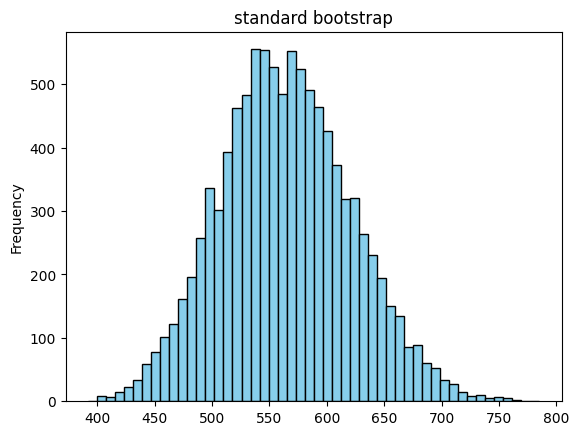

In [136]:
results_simple = sampler.iid_bootstrap()
display(results_simple.describe())
results_simple.plot(kind="hist", title="standard bootstrap", bins=50, color="skyblue", edgecolor="black");

Local Block Bootstrap Sampling: 100%|██████████| 10000/10000 [01:03<00:00, 158.08it/s]


count    10000.000000
mean       627.693300
std        106.573442
min        306.000000
25%        552.000000
50%        621.000000
75%        696.000000
max       1073.000000
Name: Bootstrap_Sums, dtype: float64


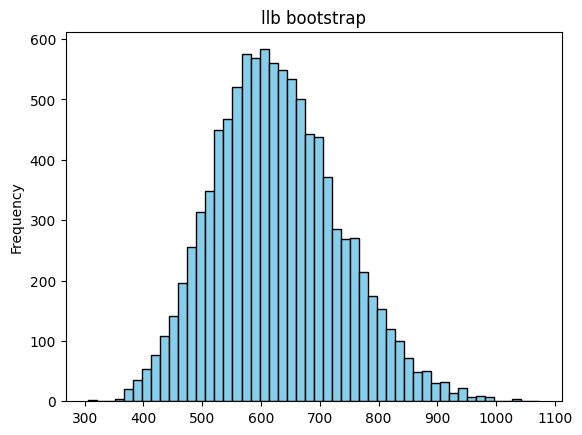

In [146]:
results_lbb = sampler.lbb(B=0.1, b=7)
print(results_lbb.describe())
results_lbb.plot(kind="hist", bins=50, title="llb bootstrap",color="skyblue", edgecolor="black");

In [ ]:
#brauche ich eine Solution-Klasse oder schreibe ich die einfach immer in eine Datei?
class Evaluation():
    def __init (self):
        pass
    #MSE evaluation
    #Wasserstein evaluation

# Normality test
- tune number of iteration until distribution is normal

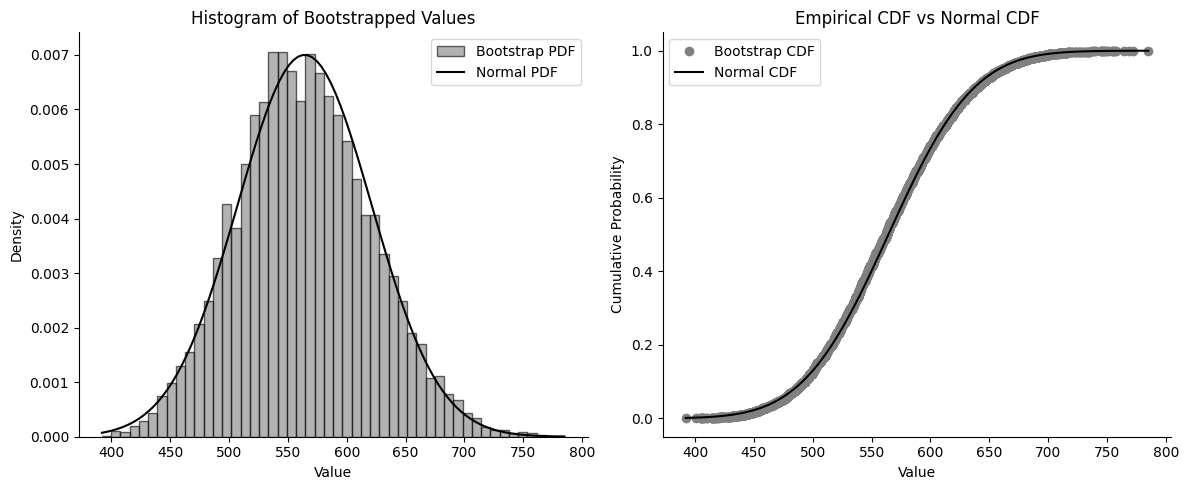

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(results_simple, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(results_simple), max(results_simple), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(results_simple)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [140]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05


In [144]:
_, p_value = stats.normaltest(results_simple)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

1.2311947696684767e-13
Reject the null hypothesis: The data does not appear to be normally distributed.


In [143]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(results_simple)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

Reject the null hypothesis: The data does not appear to be normally distributed.


/home/chnaeher/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
